In [19]:
from olv_object_detection import load_object_detector

import cv2
import matplotlib.pyplot as plt
import numpy as np
import easyocr
from typing import List, Tuple, Dict
from do_lines_intersect import do_lines_intersect
from pathlib import Path

In [20]:
image_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/full_images/curie_2.jpg")

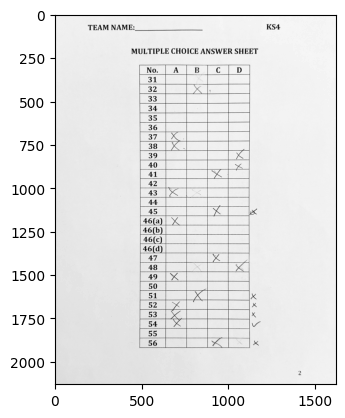

In [21]:
img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2GRAY)
img_cropped = img[200:-200, 100:-100]
plt.imshow(img_cropped, cmap="gray")

In [22]:
reader = easyocr.Reader(['en'])  # 'en' is for English; you can add more languages
# Perform OCR on the image
results: List[Tuple[List[List[int]], str, float]] = reader.readtext(img_cropped)

In [23]:
ocr_box_lines = []
for result in results:
    for i, box_corner in enumerate(result[0]):
        ocr_box_lines.append([result[0][i%4], result[0][(i+1)%4]])
    if "No" in result[1]:
        no_box_y_coord = result[0][0][1]

In [24]:
image = cv2.GaussianBlur(img_cropped, (5, 5), 0)
edges = cv2.Canny(image, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges,1,np.pi/180,215, None, 0, 0)

In [25]:
# remove all lines that cross through more than 4 ocr box lines
h, w = image.shape[:2]

intersection_counts_dict = {i:0 for i in range(len(lines))}
for line_idx, line in enumerate(lines):
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2*w*(-b))
    y1 = int(y0 + 2*h*(a))
    x2 = int(x0 - 2*w*(-b))
    y2 = int(y0 - 2*h*(a))

    for ocr_box_line in ocr_box_lines:
        ocr_box_line_input = [ocr_box_line[0][0], ocr_box_line[0][1], ocr_box_line[1][0], ocr_box_line[1][1]]

        if do_lines_intersect(ocr_box_line_input, [x1, y1, x2, y2]):
            intersection_counts_dict[line_idx] += 1

indices_to_remove = []

for line_idx in intersection_counts_dict:
    if intersection_counts_dict[line_idx] > 10:
        indices_to_remove.append(line_idx)

lines = np.delete(lines, indices_to_remove, axis=0)



number of Hough lines: 91
Number of filtered lines: 40


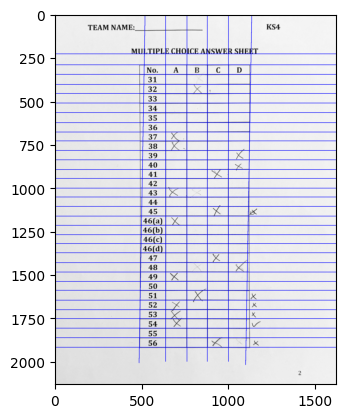

In [26]:
# image = cv2.GaussianBlur(img_cropped, (5, 5), 0)
# edges = cv2.Canny(image, 50, 150, apertureSize=3)
# lines = cv2.HoughLines(edges,1,np.pi/180,230, None, 0, 0)

to_filter = True

# idea: iteratively increase the rho and theta thresholds, and score lines based on points
# always take the line with the more points

# rho_theta_thresholds = [(0.1, 0.01), (1, 0.1), (3, 0.2), (7, 0.3), (10, 0.4), (20, 0.5), (30, 0.6), (40, 0.7)]

# for rho_threshold, theta_threshold in rho_theta_thresholds:
#     if to_filter:
#         pass

# tactic: put them all into theta ranges

# theta_range_dict = {(i, j):0 for i, j in zip(np.linspace(0, np.pi, 200)[:-1], np.linspace(0, np.pi, 200)[1:])}

# print(len(lines))

# for i in range(len(lines)):
#     rho_i,theta_i = lines[i][0]

#     for theta_range in theta_range_dict:
#         if theta_i <= theta_range[1] and theta_i > theta_range[0]:
#             theta_range_dict[theta_range] += 1
#             break

# # print(f"number of non-zero bins: {sum(np.array(list(theta_range_dict.values())) > 0)}")

# # for theta_range in theta_range_dict:
# #     if theta_range_dict[theta_range] > 0:
# #         print(f"Range: {theta_range} Counts: {theta_range_dict[theta_range]}")

# sorted_theta_range_dict = dict(sorted(theta_range_dict.items(), key=lambda item: item[1], reverse=True))

# ranges_to_accept = list(sorted_theta_range_dict.keys())[:1]

# # currently, just accept horizontal and vertical

# # ranges_to_accept = [(0, 0.1), (np.pi/2 -0.1, np.pi/2 + 0.1)]

# print(ranges_to_accept)

# indices_to_delete = []
# for i in range(lines.shape[0]):
#     outside_of_range1 = lines[i][0][1] <= ranges_to_accept[0][0] or lines[i][0][1] >= ranges_to_accept[0][1]
#     outside_of_range2 = lines[i][0][1] <= ranges_to_accept[1][0] or lines[i][0][1] >= ranges_to_accept[1][1]

#     if outside_of_range1 and outside_of_range2:
#         indices_to_delete.append(i)
#     else:
#         if not outside_of_range1:
#             print(f"Inside {ranges_to_accept[0]}")
#         if not outside_of_range2:
#             print(f"Inside {ranges_to_accept[1]}")

# lines = np.delete(lines, indices_to_delete, axis=0)

if to_filter:
    rho_threshold = 40
    theta_threshold = 0.7

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue
            
            lines[i][0][0] = np.abs(lines[i][0][0])
            lines[j][0][0] = np.abs(lines[j][0][0])

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]

            if abs(rho_i - rho_j) < rho_threshold and (abs(theta_i - theta_j) < theta_threshold or (np.pi - abs(theta_i - theta_j)) < theta_threshold):
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and (abs(theta_i - theta_j) < theta_threshold or (np.pi - abs(theta_i - theta_j)) < theta_threshold):
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

filtered_lines = []

if to_filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

image_with_lines = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
filtered_lines_cartesian = []
for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    cv2.line(image_with_lines,(x1,y1),(x2,y2),(0,0,255),2)

    filtered_lines_cartesian.append([x1, y1, x2, y2])

plt.imshow(image_with_lines)


In [27]:
# crop all questions according to the coordinates
# TODO: find the intersections for all lines, and use this to calculate the centres for answers for each question row later on

from olv_primitives import Bbox

# split into vertical and horizontal lines
vertical_lines = []
horizontal_lines = []

for line in filtered_lines_cartesian:
    if abs(line[0]-line[2]) > abs(line[1]-line[3]):
        horizontal_lines.append(line)
    else:
        vertical_lines.append(line)
# remove middle vertical lines
vertical_lines = [vertical_line for vertical_line in vertical_lines if vertical_line[0] > 0]
vertical_lines.sort(key=lambda x : x[0])
# vertical_lines = [vertical_lines[0]] + [vertical_lines[-1]]

# find the No. OCR coords
horizontal_lines = [horizontal_line for horizontal_line in horizontal_lines if horizontal_line[1] > no_box_y_coord-70]

In [28]:
from collections import defaultdict


def line_intersection(line1, line2):

    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    # Calculate the denominators and numerators for intersection formula
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None  # Lines are parallel or collinear

    # Calculate the intersection point
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator
    
    # Check if the intersection point is within both line segments
    if (min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and
        min(x3, x4) <= intersect_x <= max(x3, x4) and min(y3, y4) <= intersect_y <= max(y3, y4)):
        return (intersect_x, intersect_y)
    
    return None  # The intersection is outside the segment bounds

def find_intersections(horizontal_lines: List[List[int]], vertical_lines: List[List[int]]) -> List[Bbox]:
    # sort both
    horizontal_lines.sort(key=lambda x: x[1])
    vertical_lines.sort(key= lambda x: x[0])

    intersection_points_by_idx = defaultdict(list)
    for vline_idx, vertical_line in enumerate(vertical_lines):
        for horizontal_line in horizontal_lines:
            intersection_point = line_intersection(horizontal_line, vertical_line)

            if intersection_point is not None:
                intersection_points_by_idx[vline_idx].append(intersection_point)
    
    for vline_idx in intersection_points_by_idx:
        assert len(intersection_points_by_idx[vline_idx]) == len(horizontal_lines)
    
    class_midpoints_by_horizontal_line = defaultdict(list)
    for i in range(len(horizontal_lines)):
        for vline_idx in intersection_points_by_idx:
            if vline_idx == 0 or vline_idx == len(intersection_points_by_idx) - 1:
                continue
            class_midpoints_by_horizontal_line[i].append((intersection_points_by_idx[vline_idx][i][0] + intersection_points_by_idx[vline_idx+1][i][0])/2 - intersection_points_by_idx[0][i][0])
    
    coords1 = intersection_points_by_idx[0]
    coords2 = intersection_points_by_idx[len(vertical_lines) - 1]
    assert len(coords1) == len(coords2)
    output = []
    for i in range(len(coords1)):
        try:
            output.append((coords1[i], coords2[i+1]))
        except IndexError:
            pass
    
    output_parsed = [Bbox.from_absolute(xtl, ytl, xbr, ybr, w, h) for ((xtl, ytl), (xbr, ybr)) in output]

    return output_parsed, class_midpoints_by_horizontal_line

In [29]:
all_lines = horizontal_lines + vertical_lines
crop_bboxes, class_midpoints = find_intersections(horizontal_lines, vertical_lines)

In [30]:
from olv_draw import draw_bbs, DrawParameters
from PIL import Image, ImageDraw

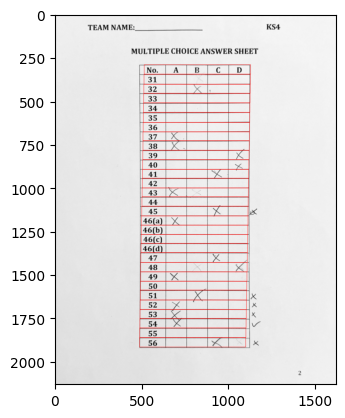

In [31]:
image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
image_canvas = ImageDraw.Draw(image_pil)
draw_parameters = DrawParameters(fill_color=None)

draw_bbs(image_canvas, crop_bboxes, draw_parameters)

plt.imshow(np.array(image_pil))


In [32]:
from pathlib import Path

cropped_image_save_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/cropped_data/images")

In [33]:
from typing import Dict
def get_xcentres_for_each_answer(easyocr_detections: Tuple[List[int], str, float]) -> Dict[float, str]:
    output = {}

    for easyocr_detection in easyocr_detections:
        output[easyocr_detection[0][0][0] + easyocr_detection[0][2][0]] = easyocr_detection[1]
    
    return output

In [34]:
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

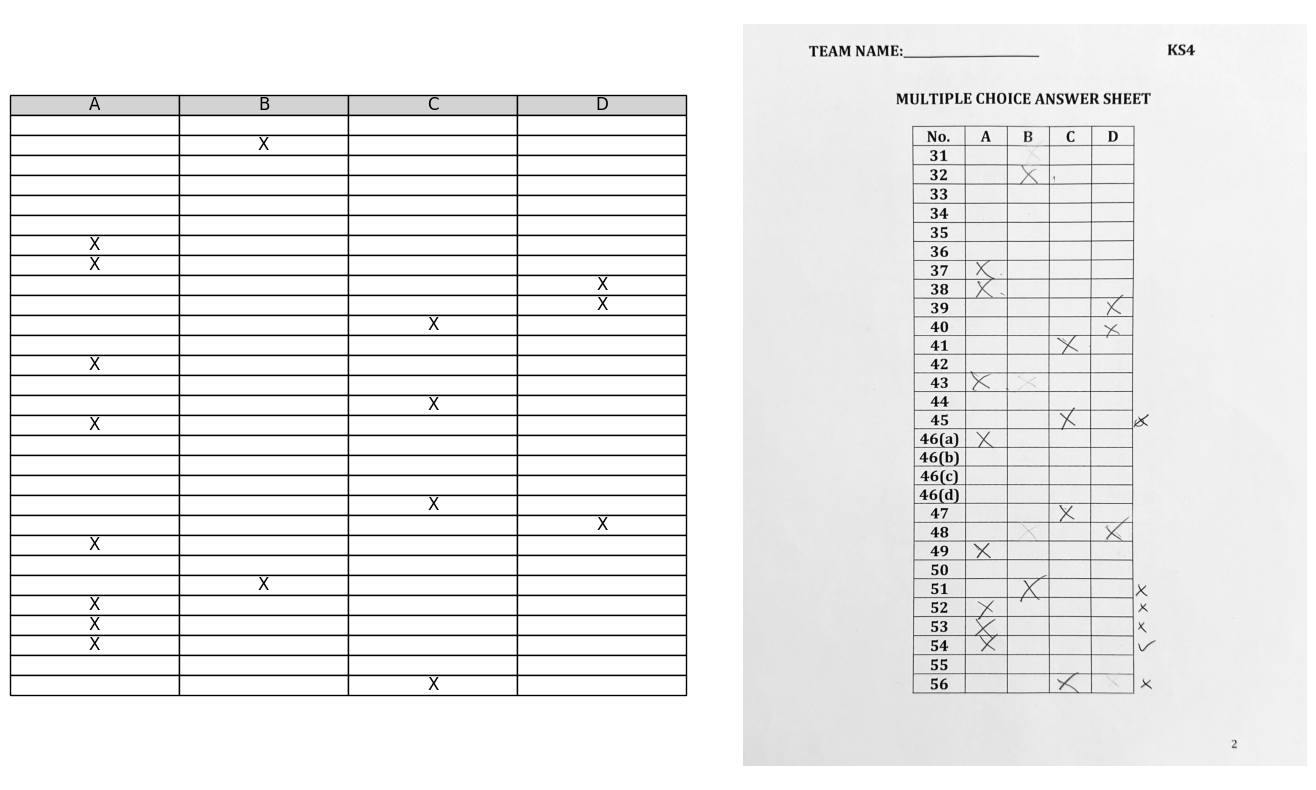

In [35]:
detector_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/models/object_detection/yolov5/20241105/140517/model.detector")
detector = load_object_detector(detector_path)

df_cols = ['A', 'B', 'C', 'D']
df = pd.DataFrame(columns=df_cols)

label_box = True
image_image_folder = cropped_image_save_path / image_path.stem
image_image_folder.mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(crop_bboxes):
    bbox_cropped_image = image[int(bbox.ytl):int(bbox.ybr), int(bbox.xtl):int(bbox.xbr)]
    if label_box is True:
        label_box = False
        continue

    centres_for_answers = {mid:cls for mid, cls in zip(class_midpoints[i], df_cols)}
    new_row = {'A': " ", 'B': " ", 'C': " ", 'D': " "}
    detections = detector.infer_parsed(bbox_cropped_image)
    for detection in detections:
        if detection.conf < 0.7:
            continue
        centre_x = detection.mid.x
        diff = np.Inf
        for answer_x in centres_for_answers:
            diff_ans = abs(centre_x-answer_x)
            if diff_ans < diff:
                answer = centres_for_answers[answer_x]
                diff = diff_ans

        new_row[answer] = "X"

    df.loc[len(df)] = list(new_row.values())

    image_name = reader.readtext(bbox_cropped_image)[0][1]
    image_save_path = image_image_folder / f"{image_name}.jpg"

    cv2.imwrite(str(image_save_path), bbox_cropped_image)

# Create a plot and hide the axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))  # Set the figure size

# Hide the axes
ax[0].axis('off')
ax[1].axis('off')

# Create the table and add it to the plot
table = ax[0].table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["lightgray"]*df.shape[1])

# Customize the table (optional)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax[1].imshow(img_cropped, cmap="gray")

# Display the plot
plt.show()

In [36]:
csv_folder_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/csvs")

csv_file_path = csv_folder_path /  f"{image_path.stem}.csv"


df.to_csv(csv_file_path)